# GAN For Face Detection

## Importing

In [1]:
from torchvision.datasets import CelebA, ImageFolder
import torchvision.transforms as ttran

## Hyperparameters

In [5]:
IMG_SIZE = 300
IMGS_PATH = '/kaggle/input/celeba-dataset/img_align_celeba/'

## Transform

In [3]:
train_transform = ttran.Compose([ttran.Resize((300, 300)), ttran.PILToTensor()])
test_transform = ttran.Compose([ttran.Resize((300, 300)),ttran.PILToTensor()])

## Dataset

In [6]:

#train_ds = CelebA('/kaggle/working/data/', split='train', download=True, transform=train_transform)
#test_ds = CelebA('/kaggle/working/data/', split='test', download=True, transform=test_transform)

ds = ImageFolder(IMGS_PATH, train_transform)


In [7]:
img, label = ds[0]

## Arquitetura do Modelo

### MLP GAN
Iniciaremos uma MLP GAN, a qual tem ambos o gerador e o discriminador sendo compostos apenas por camadas densas.

### DCGAN
O modelo será composto por dois blocos principais:
- gerador: uma CNN treinada para gerar imagens ao invés de classificá-las (usa camadas convolucionais transpostas, para fazer o caminho inverso). Usará perda em conjunto com o discriminador.
- discriminador: uma CNN treinada em comparação com o dataset (CelebA) para classificação binária (é um item do dataset ou não). Usará perda focada no discriminador apenas.


Existem outras redes GANs, como GANs condicionais que, ao que aparentam, recebem como entrada um dado adicional (não apenas ruído).

## Criação do Modelo

### Gerador

In [ ]:
from torch import nn
import torch

class Generator(nn.Module):

    def __init__(self, num_features, output_size=300):
        """
            - *num_features*: generator input size
            - *output_size*: image size (for square RGB images)
        """
        super().__init__()
        self.output_size = output_size
        flattened_img_size = output_size*output_size*3

        self.layers = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, flattened_img_size),
            nn.Sigmoid()
        )


    def forward(self, input):
        img = self.layers(input)
        reshaped_img = img.reshape(-1, 3, self.output_size, self.output_size) # (B, C, H, W) # batches, channels, height, width
        reshaped_img = reshaped_img * 255 # values are between 0 and 1, so we multiply by 255 to make them rgb values.
        return reshaped_img

In [35]:
generator = Generator(100, 300) # Creating Generator

#### Gerando Imagem Aleatória

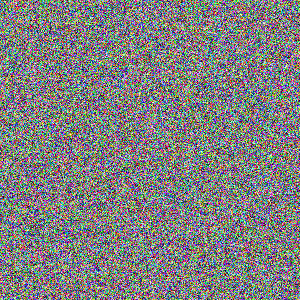

In [61]:
from torchvision.transforms.functional import to_pil_image

result = generator(torch.rand(3, 100))

display(to_pil_image(result[0]))

### Discriminador

In [46]:
from torch import nn
import torch

class Discriminator(nn.Module):

    def __init__(self, img_size):
        """
            - *img_size*: image size (for square RGB images)
        """
        super().__init__()
        flattened_img_size = img_size*img_size*3

        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_img_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )


    def forward(self, img):

        img = img / 255
        output = self.layers(img)

        return output

In [56]:
discriminator = Discriminator(IMG_SIZE)

#### Testando discriminador

In [45]:
result.shape

torch.Size([1, 3, 300, 300])

In [62]:
discriminator(result)

tensor([[0.5182],
        [0.5182],
        [0.5182]], grad_fn=<SigmoidBackward0>)